Link dataset: https://www.kaggle.com/datasets/aryashah2k/credit-card-customer-data/code

### Significado de variables
- **Sl_No:** Número de identificación de serie del cliente: Sirve para indexar valores
- **Customer Key** 
- **Avg_Credit_Limit:** Límite promedio de la tarjeta de crédito para el cliente
- **Total_Credit_Cards:**  Total de tarjetas de crédito del cliente
- **Total_visits_bank:**  Número total de visitas del cliente al banco
- **Total_visits_online:**  Total de visitas en línea del cliente del banco
- **Total_calls_made:** Total de llamadas realizadas por el cliente al banco

En este notebook se aplicarán tres técnicas de clustering sobre el mismo conjunto de datos y, al final, se compararán sus resultados.

## Técnicas de clustering

### k-means
- Particiona los datos en _k_ clusters, minimizando la suma de distancias al cuadrado entre cada punto y el centroide de su cluster.  
- Requiere especificar de antemano el número de clusters (_k_).  
- Ideal para clusters de forma convexa y similar tamaño.

### DBSCAN
- Clustering basado en densidad: agrupa puntos con alta densidad local y etiqueta como “ruido” los puntos dispersos.  
- No requiere número de clusters previo, pero sí dos parámetros: _eps_ (radio de vecindad) y _min_samples_ (mínimo de puntos).  
- Capta clusters de forma arbitraria y es robusto al ruido.

### BFR (Bradley-Fayyad-Reina)
- Algoritmo _online_ para clustering de grandes volúmenes de datos, basado en modelos gaussianos parciales.  
- Resume cada cluster con estadísticas suficientes (_CF vectors_) y procesa datos por _chunks_.  
- Muy eficiente en memoria y tiempo para datasets que no caben en memoria completa.

## Flujo de trabajo
1. **Carga y preprocesamiento**  
   - Limpieza, escalado y reducción de dimensionalidad (opcional).  
2. **Entrenar k-means**  
3. **Entrenar DBSCAN**  
4. **Entrenar BFR**  
5. **Evaluar y comparar resultados**

## Comparación de técnicas
Para cuantificar la calidad de agrupamiento y compararlas de forma homogénea, utilizaremos:

**Coeficiente de Silhouette**  
- Mide la cohesión interna (distancia media al propio cluster) frente a la separación con otros clusters.  
- Rango: \(-1\) (mal asignado) a \(+1\) (cluster bien definido).  
- Aplicable a **k-means**, **DBSCAN** (considerando o ignorando ruido) y **BFR**.  
- Implementación recomendada:  
  ```python
  from sklearn.metrics import silhouette_score
  score = silhouette_score(X, labels)


In [224]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, DBSCAN

### 1. Carga y procesamiento

In [225]:
df = pd.read_csv('Credit Card Customer Data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [226]:
# Quitamos Custumer key del dataframe
df.drop(columns=['Customer Key'], inplace=True)
# Quitamos SI_No del dataframe
df.drop(columns=['Sl_No'], inplace=True)

df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


In [227]:
# Veamos cuantos son los datos nulos
print(df.isnull().sum())

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64


In [228]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


## Análisis de la distribución de **Avg_Credit_Limit**

- **Mediana (18 000)**  
  La “cintura” del violin y la transición de color en la tira de calor confirman que la mitad de los clientes tiene un límite de crédito ≤ 18 000.

- **Rango intercuartílico (10 000 – 48 000)**  
  El grueso de la densidad (la parte más ancha del violin) está entre 10 000 y 48 000, mostrando dónde se concentra el 50 % central de los datos.

- **Asimetría positiva**  
  La nube se estrecha rápidamente hacia valores altos y la cola derecha se alarga hasta 200 000, indicando que unos pocos clientes disponen de límites muy altos.

- **Valores atípicos**  
  Se aprecian puntos aislados por encima de los 100 000, que reflejan unos cuantos casos extremos.

- **Variabilidad elevada (std ≈ 37 625)**  
  La dispersión es amplia, lo que sugiere heterogeneidad en los límites otorgados a los clientes.

### Ver el grafico a continuación

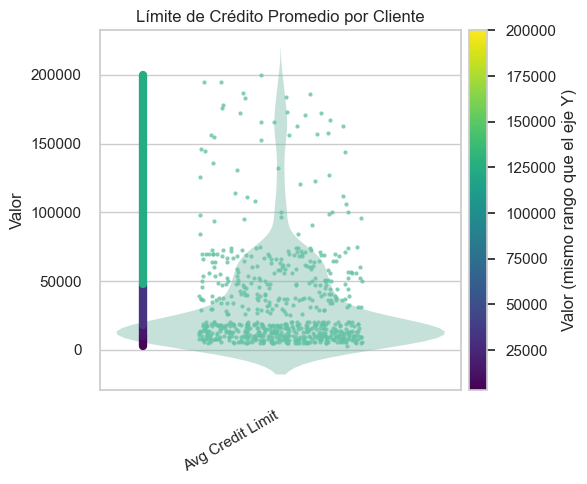

In [229]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

col = 'Avg_Credit_Limit'
data = df[[col]]

plt.figure(figsize=(6, 5))
sns.set_style("whitegrid")
palette = sns.color_palette("Set2", 1)
norm = Normalize(vmin=data[col].min(), vmax=data[col].max())
ax = plt.gca()


x = np.zeros_like(data[col], dtype=float)
sns.violinplot(y=data[col], x=x, inner=None,
               color=palette[0], width=.6, linewidth=0, alpha=.4)
sns.stripplot(y=data[col], x=x, size=3,
              color=palette[0], jitter=.15, alpha=.8)


stats = data[col].describe()
q = stats[['min', '25%', '50%', '75%', 'max']].values
y0, y1 = q[:-1], q[1:]
for y_start, y_end in zip(y0, y1):
    ax.plot([-0.25, -0.25], [y_start, y_end], lw=6,
            color=plt.cm.viridis(norm((y_start + y_end) / 2)))


ax.set_xticks([0])
ax.set_xticklabels([col.replace('_', ' ')], rotation=30, ha='right')
ax.set_ylabel("Valor")
ax.set_title("Límite de Crédito Promedio por Cliente")


sm = ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=.02)
cbar.set_label("Valor (mismo rango que el eje Y)")

plt.tight_layout()
plt.show()

## Insights del Clustermap de Correlaciones

- **Cluster 1: Capacidad crediticia**  
  - `Avg_Credit_Limit` y `Total_Credit_Cards` se agrupan muy pronto (r≈0.61), indicando que los clientes con más tarjetas también suelen tener límites promedios mayores.

- **Cluster 2: Banca digital**  
  - `Total_visits_online` se une enseguida al grupo de crédito (r≈0.55 con Avg_Credit_Limit), lo que sugiere que los clientes con mejor perfil crediticio utilizan más la banca en línea.

- **Cluster 3: Canal presencial**  
  - `Total_visits_bank` forma su propio remanso, con correlaciones bajas o negativas frente a las métricas de crédito (r≈–0.10) y frente a la banca online (r≈–0.55), señalando un comportamiento de “todo-o-nada” entre canales.

- **Cluster 4: Llamadas al call center**  
  - `Total_calls_made` queda aislado en la cúspide: presenta correlaciones negativas fuertes con `Total_Credit_Cards` (r≈–0.65) y moderadas con visitas a sucursal (r≈–0.51), mostrando que más llamadas no implica ni más crédito ni más visitas físicas.

 **Conclusión**  
 Aparecen dos grandes familias:  
 1. **Crédito + Digital** (alto crédito ↔ uso intenso de banca online)  
 2. **Atención tradicional** (visitas y llamadas) con dinámicas casi opuestas al cluster de crédito.  


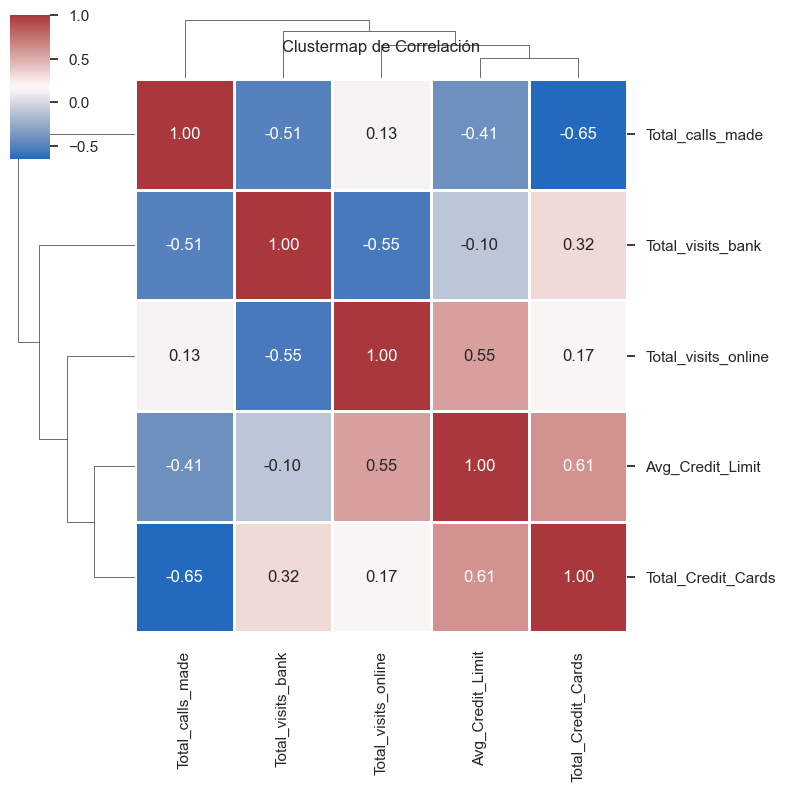

In [230]:
corr = df.corr()

# Dibuja el clustermap
sns.set(font_scale=1)
g = sns.clustermap(
    corr,
    cmap="vlag",
    linewidths=.75,
    figsize=(8, 8),
    annot=True,
    fmt=".2f",
    cbar_pos=(0.02, .8, .05, .18),
    dendrogram_ratio=(.2, .1),
    yticklabels=True,
    xticklabels=True
)
g.ax_heatmap.set_title("Clustermap de Correlación", pad=20)
plt.show()

In [231]:
# Creamos una nueva columna que se denominara 'Recency' 
df['Recency'] = df['Total_visits_bank'] + df['Total_visits_online'] + df['Total_calls_made']
# Esta variable nos indica la cantidad de interacciones que ha tenido el cliente con el banco en los últimos meses.
# Creamos una nueva columna que se denominara 'Credit_Usage'
df['Credit_Usage'] = df['Avg_Credit_Limit'] / (df['Total_Credit_Cards'] + 1)
# Esta variable nos indica el uso promedio del crédito por tarjeta.

df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Recency,Credit_Usage
0,100000,2,1,1,0,2,33333.333333
1,50000,3,0,10,9,19,12500.000000
2,50000,7,1,3,4,8,6250.000000
3,30000,5,1,1,4,6,5000.000000
4,100000,6,0,12,3,15,14285.714286


In [232]:
# Ahora escalamos las variables para que tengan la misma importancia
from sklearn.preprocessing import MinMaxScaler
# hacemos una copia del dataframe para no modificar el original
df_scaled = df[['Avg_Credit_Limit','Total_Credit_Cards','Recency', 'Credit_Usage']]
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_scaled)
df_scaled.shape

(660, 4)

## 2. Entrenar K-means

In [233]:
kmeans =KMeans(n_clusters=4, max_iter=300, init='k-means++', random_state=42)
y_kmeans= kmeans.fit_predict(df_scaled)

df['kmeans_cluster']= kmeans.labels_
df['kmeans_cluster'].value_counts()

kmeans_cluster
0    211
2    208
1    192
3     49
Name: count, dtype: int64

### Interpretación métrica: `kmeans.inertia_`

- **Baja inercia ⇒ clusters compactos**  
  Los puntos están, en promedio, más cerca de sus centroides.

- **Alta inercia ⇒ clusters dispersos**  
  Mayor variabilidad interna dentro de cada cluster.

- Al **aumentar** \(k\), la inercia siempre **disminuye** (cada punto puede quedar más cerca de algún centroide).


In [234]:
kmeans.inertia_

29.90601794683751

### Coeficiente de Silhouette para K-means

In [235]:
SParaK = silhouette_score(df_scaled, kmeans.labels_)
print(f"Silhouette Score para KMeans: {SParaK:.4f}")

Silhouette Score para KMeans: 0.3286


### Método del Codo (Elbow Method)

El Método del Codo es una técnica visual para seleccionar el número óptimo de clusters \(k\) en k-means. La idea central es:

1. **Calcular la inercia** (WCSS – Within-Cluster Sum of Squares) para distintos valores de \(k\).  
2. **Graficar** la inercia en función de \(k\).  
3. **Detectar el “codo”** en la curva: el punto donde la reducción de la inercia al aumentar \(k\) deja de ser significativa.

- A la izquierda del codo, cada cluster adicional aporta gran mejora (disminuye mucho la inercia).  
- A la derecha del codo, añadir más clusters aporta poca ganancia (la inercia apenas baja).  
- El valor de \(k\) en el codo ofrece un buen compromiso entre **compactación** (baja inercia) y **simplicidad** (pocos clusters).


<Axes: >

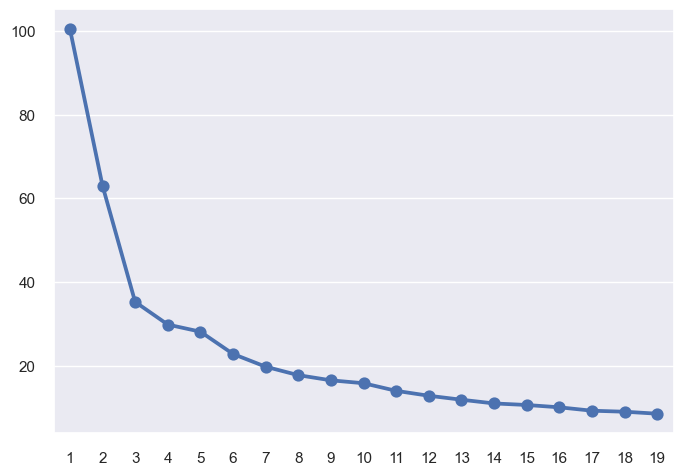

In [236]:
# Diccionario para almacenar la inercia (WCSS) por cada k
wcss = {}

# Probar valores de k desde 1 hasta 19
for k in range(1, 20):
    # Configurar y ajustar el modelo KMeans
    kmeans = KMeans(
        n_clusters=k,        # número de clusters
        max_iter=300,        # iteraciones máximas
        init='k-means++',    # inicialización de centroides
        random_state=42      # semilla para reproducibilidad
    )
    kmeans.fit(df_scaled)               # ajustar el modelo a los datos
    wcss[k] = kmeans.inertia_   # guardar la inercia (WCSS) en el diccionario

# Graficar inercia vs. número de clusters usando seaborn
sns.pointplot(
    x=list(wcss.keys()),    # lista de valores de k
    y=list(wcss.values()),  # lista de inercia correspondiente
    marker='o'
)

Al observar la curva de **inercia (WCSS) vs. número de clusters (k)**:

- **Descenso pronunciado inicial**  
  - De \(k=1\) a \(k=2\): la inercia cae de ~250 a ~185.  
  - De \(k=2\) a \(k=3\): nuevo gran descenso, de ~185 a ~85.  
  Esto indica que pasar de 1 a 3 clusters aporta enormes ganancias en compactar los datos.

- **Zona de “codo” (punto de inflexión)**  
  - Tras \(k=3\), la pendiente se suaviza:  
    - \(k=4\) ≈ 65,  
    - \(k=5\) ≈ 60,  
    - más allá de \(k=5\), cada cluster adicional reduce la inercia muy levemente.  
  - El **codo** se sitúa alrededor de **\(k=3\) o \(k=4\)**, donde la mejora empieza a estabilizarse.

- **Selección óptima de \(k\)**  
  - Elegir **\(k=3\)** o **\(k=4\)** suele ser ideal:  
    - Captura la mayor parte de la variabilidad interna.  
    - Evita un número excesivo de clusters que compliquen la interpretación.


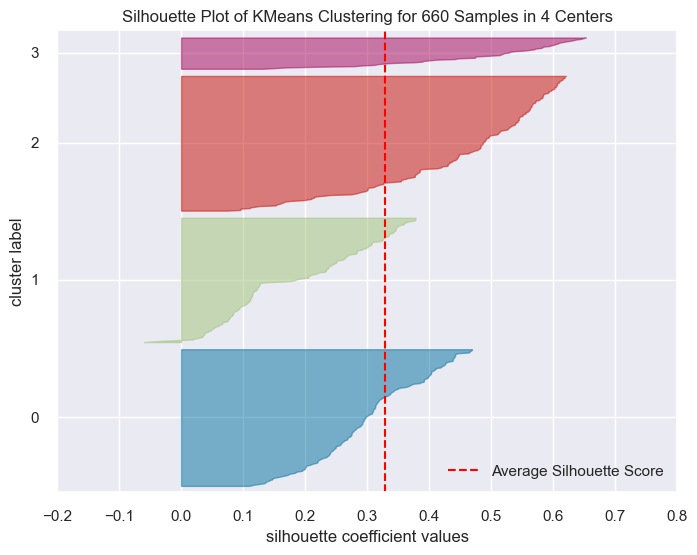

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [237]:
from yellowbrick.cluster import SilhouetteVisualizer

# Definir el número de clusters
n_clusters = 4

# Inicializar el modelo KMeans con semilla para reproducibilidad
kmeans = KMeans(
    n_clusters=n_clusters,
    init='k-means++',
    random_state=42
)

# Opcional: ajustar el tamaño de la figura
plt.figure(figsize=(8, 6))

# Crear el visualizador de Silhouette
visualizer = SilhouetteVisualizer(
    kmeans,
    colors='yellowbrick'
)

# Ajustar el visualizador a los datos (entraña fit y predict)
visualizer.fit(df_scaled)
visualizer.ax.set_title(f"Diagrama de Silhouette para KMeans (k={n_clusters})") 
visualizer.show()


### 3. Entrenar DBscan 

### Búsqueda de parámetros óptimos para DBSCAN

#### Objetivo
Realizar una exploración exhaustiva de combinaciones de **eps** (radio de vecindad) y **min_samples** (mínimo de puntos) para el algoritmo DBSCAN, con el fin de maximizar la puntuación de Silhouette sobre el dataset escalado.

#### Parámetros evaluados
- **eps:** lista de radios de vecindad a probar.  
- **min_samples:** lista de valores mínimos de puntos para formar un clúster.

#### Variables de control
- **best_score:** almacena la mejor puntuación de Silhouette encontrada.  
- **best_eps / best_m:** guardan los valores de eps y min_samples que producen esa mejor puntuación.

#### Flujo de trabajo
1. **Recorrer todas las combinaciones** de eps y min_samples mediante bucles anidados.  
2. **Ajustar DBSCAN** con la combinación actual y obtener las etiquetas de cluster.  
3. **Contar clusters válidos**, ignorando el ruido (etiqueta –1), y descartar configuraciones que produzcan un único cluster o ninguno.  
4. **Calcular la puntuación de Silhouette** para medir la cohesión interna y la separación entre clusters.  
5. **Actualizar los parámetros óptimos** si la puntuación actual supera a la mejor registrada, e imprimir inmediatamente la nueva mejor configuración.


In [238]:
import itertools
# Definición de parámetros a evaluar
radios_eps    = [ 0.01, 0.02, 0.03, 0.05, 0.08, 0.05, 0.015, 0.025]
min_muestras  = [5, 8, 10, 15, 16,18, 20]

#  Variables para llevar el mejor resultado
mejor_puntuacion = -1
mejor_eps        = None
mejor_min        = None

# Exploración de todas las combinaciones
for eps_val, min_val in itertools.product(radios_eps, min_muestras):
    dbscan    = DBSCAN(eps=eps_val, min_samples=min_val)
    etiquetas = dbscan.fit_predict(df_scaled)

    # Verificar si hay al menos un cluster
    if len(set(etiquetas)) <= 1:
        continue  # Si no hay clusters, saltar a la siguiente combinación

    # Calcular la puntuación de Silhouette
    puntuacion = silhouette_score(df_scaled, dbscan.labels_)
    
    # Actualizar mejor configuración
    if puntuacion > mejor_puntuacion:
        mejor_puntuacion = puntuacion
        mejor_eps = eps_val
        mejor_min = min_val

# Mostrar la mejor combinación encontrada
print(f"Mejor puntuación Silhouette: {mejor_puntuacion:.4f}")
print(f"eps óptimo = {mejor_eps}")
print(f"min_samples óptimo = {mejor_min}")

Mejor puntuación Silhouette: 0.0580
eps óptimo = 0.08
min_samples óptimo = 5


In [239]:
dbscan = DBSCAN(eps=0.08, min_samples=5)
y_db= dbscan.fit_predict(df_scaled)


### Coeficiente de Silhouette para DBscan

In [240]:
SParaDB = silhouette_score(df_scaled,dbscan.labels_)
print(f"Silhouette Score para DBSCAN: {SParaDB:.4f}")

Silhouette Score para DBSCAN: 0.0580


In [241]:
# Veamos cuantas etiquetas nos ha dado DBSCAN
df['dblabel']= dbscan.labels_
df['dblabel'].value_counts()

dblabel
 3    149
 7    114
 0     91
-1     69
 1     66
 5     61
 2     51
 4     51
 6      8
Name: count, dtype: int64

In [242]:
etiquetas_unicas = np.unique(y_db)
print(f"Cantidad de etiquetas únicas: {len(etiquetas_unicas)}")

Cantidad de etiquetas únicas: 9


## Visualización de clusters con DBSCAN

Este gráfico muestra cómo el algoritmo **DBSCAN** ha agrupado a los clientes según:
- **Eje X:** número total de tarjetas de crédito.
- **Eje Y:** recencia, es decir, días transcurridos desde su última interacción.


**Interpretación rápida:**  
- Identifica grupos de clientes con patrones similares de crédito y recencia.  
- Observa si existen clientes atípicos (ruido) o agrupaciones densas de comportamiento.  
- Útil para diseñar estrategias de retención o segmentación basada en uso de la tarjeta.


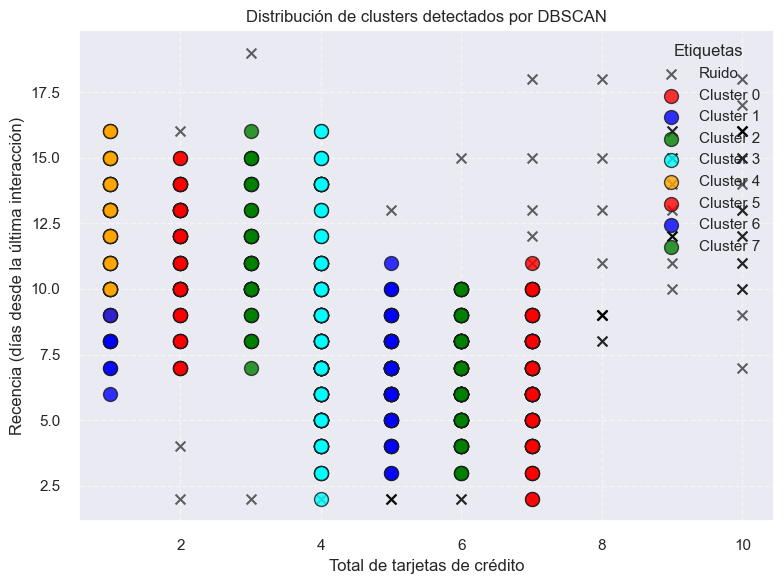

In [243]:
# Tamaño de la figura
plt.figure(figsize=(8, 6))

# Definir paleta de colores para clusters (el ruido se pinta en gris)
colores = ["red", "blue", "green", "cyan", "orange"]

# Determinar etiquetas únicas (-1 = ruido)
etiquetas_unicas = np.unique(y_db)

for etiqueta in etiquetas_unicas:
    # Subconjunto de datos para esta etiqueta
    datos_cluster = df[y_db == etiqueta]
    
    if etiqueta == -1:
        # Graficar el ruido con 'x' y color gris
        plt.scatter(
            datos_cluster['Total_Credit_Cards'],
            datos_cluster['Recency'],
            s=50,
            c='black',
            marker='x',
            label='Ruido',
            alpha=0.6
        )
    else:
        # Graficar cada cluster con color y borde negro
        color = colores[int(etiqueta) % len(colores)]
        plt.scatter(
            datos_cluster['Total_Credit_Cards'],
            datos_cluster['Recency'],
            s=100,
            c=color,
            edgecolors='k',
            label=f"Cluster {etiqueta}",
            alpha=0.8
        )

# Etiquetas y estilo
plt.xlabel("Total de tarjetas de crédito")
plt.ylabel("Recencia (días desde la última interacción)")
plt.title("Distribución de clusters detectados por DBSCAN")
plt.legend(title="Etiquetas", loc="upper right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()